# Start from curve + Spline merging

for noise-free points only

In [1]:
from PIL import Image
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from time import perf_counter


Generate spline

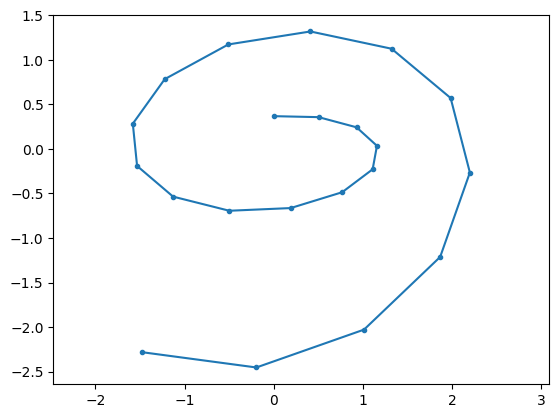

In [2]:
N = 20

def fun(t):
    return np.array([
        np.exp(t)*np.sin(10.0*t),
        np.exp(2*t-1)*np.cos(10.0*t)
    ]).T

initial_t = np.linspace(0, 1, N+1)
initial_p = fun(initial_t)

plt.figure()
plt.plot(initial_p[:,0], initial_p[:,1], '.-')
plt.axis("equal")
plt.show()

Endpoint tangents

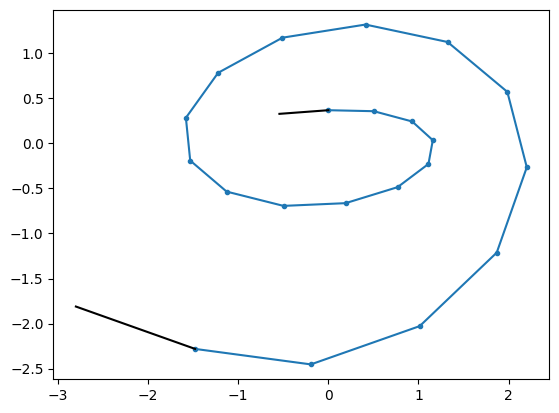

In [3]:
# solve for coefficients from second order Taylor series
# (assume uniform dt)
d0 = [-1.5, 2, -0.5] @ initial_p[:3]
d1 = [0.5, -2, 1.5] @ initial_p[-3:]

plt.figure()
plt.plot(initial_p[:,0], initial_p[:,1], '.-')
plt.plot(initial_p[0,0]-[0,d0[0]], initial_p[0,1]-[0,d0[1]], 'k-')
plt.plot(initial_p[-1,0]+[0,d1[0]], initial_p[-1,1]+[0,d1[1]], 'k-')
plt.axis("equal")
plt.show()

Interpolate spline (C2 cubic with end tangents)

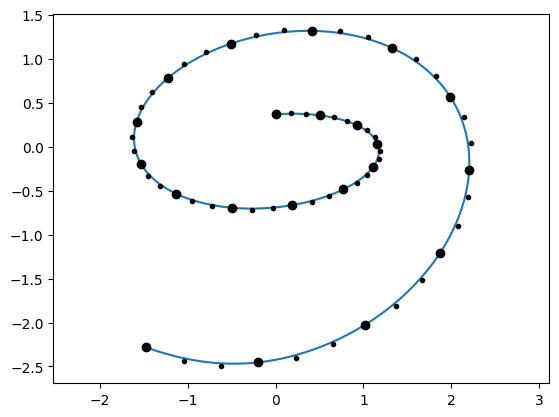

In [4]:
def compute_c1_c2(ps):
    n = len(ps)-1
    d0 = [-1.5, 2, -0.5] @ ps[:3]
    d1 = [0.5, -2, 1.5] @ ps[-3:]

    A = np.zeros((2*n, 2*n), dtype=np.double)
    b = np.zeros((2*n, 2), dtype=np.double)

    A[0,0] = 3.0
    b[0] = 3.0*ps[0] + d0
    for i in range(n-1):
        A[2*i+1, 2*i+1:2*i+3] = [1.0, 1.0]
        b[2*i+1] = 2.0*ps[i+1]
        A[2*i+2, 2*i:2*i+4] = [1.0, -2.0, 2.0, -1.0]
    A[2*n-1, 2*n-1] = 3.0
    b[2*n-1] = 3.0*ps[-1] - d1

    x = np.linalg.inv(A) @ b

    return x[2*np.arange(n)], x[2*np.arange(n)+1]


initial_c1, initial_c2 = compute_c1_c2(initial_p)

plt.figure()
for i in range(N):
    t = np.linspace(0, 1).reshape(-1, 1)
    p = (1-t)**3 * initial_p[i] + \
        3*t*(1-t)**2 * initial_c1[i] + \
        3*t**2*(1-t) * initial_c2[i] + \
        t**3 * initial_p[i+1]
    plt.plot(p[:,0], p[:,1], 'C0-')
plt.plot(initial_p[:,0], initial_p[:,1], 'ko')
plt.plot(initial_c1[:,0], initial_c1[:,1], 'k.')
plt.plot(initial_c2[:,0], initial_c2[:,1], 'k.')
plt.axis("equal")
plt.show()

Error metrics

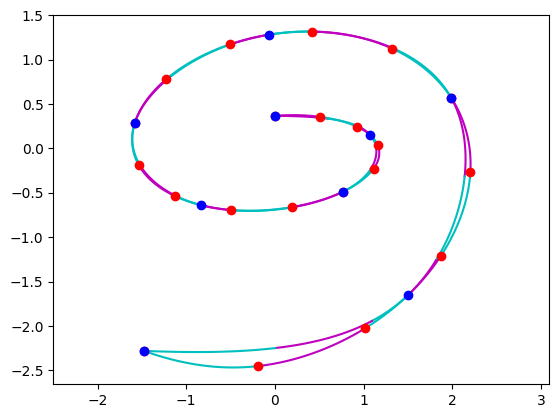

In [5]:
# https://cs.nyu.edu/~sw4429//files/paper/sa23-bezier.pdf


def unwrap_cubic_spline(cps, t0, t1):
    """Unwrap Bezier curve with control points c0,c1,c2,c3 between t0,t1 to
        polynomial spline with a0,a1,a2,a3 between 0,1"""
    coeffs = np.array([
        [1, 0, 0, 0],
        [-3, 3, 0, 0],
        [3, -6, 3, 0],
        [-1, 3, -3, 1]
    ]) @ cps
    dt = t1-t0
    return np.array([
        [1, t0, t0**2, t0**3],
        [0, dt, 2*t0*dt, 3*t0**2*dt],
        [0, 0, dt**2, 3*t0*dt**2],
        [0, 0, 0, dt**3]
    ]) @ coeffs


def get_loss(ts, ps, c1s, c2s, verbose=False):

    all_ss = []  # (s, is_initial, idx)
    for i, t in enumerate(initial_t):
        all_ss.append((t, True, i))
    for i, t in enumerate(ts):
        all_ss.append((t, False, i))
    all_ss.sort(key=lambda _: _[0])

    total_loss = 0.0
    sp0i, sp1i = 0, 0
    piece_i = 0
    for (s0, g0, i0), (s1, g1, i1) in zip(all_ss[:-1], all_ss[1:]):
        if g0:
            sp0i = i0
        else:
            sp1i = i0
        if not s0 < s1:
            continue
        piece_i += 1

        # first piece
        cps0 = (
            initial_p[sp0i], initial_c1[sp0i], initial_c2[sp0i],
            initial_p[sp0i+1]
        )
        t00, t01 = initial_t[sp0i], initial_t[sp0i+1]
        ts0 = ((s0-t00)/(t01-t00), (s1-t00)/(t01-t00))
        assert 0 <= ts0[0] < ts0[1] <= 1
        coeffs0 = unwrap_cubic_spline(cps0, *ts0)
        if verbose:
            t = np.linspace(0, 1).reshape(-1, 1)
            p = t**[0,1,2,3] @ coeffs0
            plt.plot(p[:,0], p[:,1], ['c-', 'm-'][piece_i%2])

        # second piece
        cps1 = (ps[sp1i], c1s[sp1i], c2s[sp1i], ps[sp1i+1])
        t10, t11 = ts[sp1i], ts[sp1i+1]
        ts1 = ((s0-t10)/(t11-t10), (s1-t10)/(t11-t10))
        assert 0 <= ts1[0] < ts1[1] <= 1
        coeffs1 = unwrap_cubic_spline(cps1, *ts1)
        if verbose:
            t = np.linspace(0, 1).reshape(-1, 1)
            p = t**[0,1,2,3] @ coeffs1
            plt.plot(p[:,0], p[:,1], ['c-', 'm-'][piece_i%2])

        # integral
        dc = coeffs1 - coeffs0
        dc_pows = np.einsum('ai,bi->ab', dc, dc) / np.array(
            [[1, 2, 3, 4],
             [2, 3, 4, 5],
             [3, 4, 5, 6],
             [4, 5, 6, 7]])
        loss = np.sum(dc_pows)

        # add loss
        dx0 = (ts0[1]-ts0[0])/N
        dx1 = (ts1[1]-ts1[0])/(len(ts)-1)
        # if not (abs(dx1-dx0) < 1e-6):
        #     print(dx0, dx1)
        #     assert False
        weight = dx0/(t01-t00) + dx1/(t11-t10)
        weight = dx0
        total_loss += weight * loss
    
    return total_loss


n1 = 8
ts = np.linspace(0, 1, n1+1)
ps = fun(ts)
c1s, c2s = compute_c1_c2(ps)

plt.figure()
get_loss(ts, ps, c1s, c2s, True)
plt.plot(initial_p[:,0], initial_p[:,1], 'ro')
plt.plot(ps[:,0], ps[:,1], 'bo')
plt.axis("equal")
plt.show()

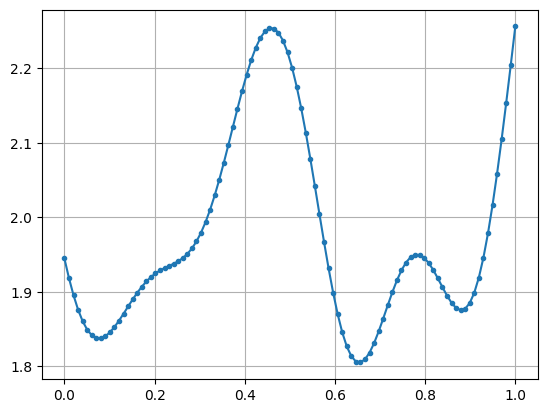

In [6]:
# make sure there's not discontinuity

n1 = 2
t_mids = np.linspace(0, 1, 100)
losses = []

for t_mid in t_mids:
    ts = np.linspace(0, 1, n1+1)
    ts[1] = t_mid
    ps = fun(ts)
    c1s, c2s = compute_c1_c2(ps)
    loss = get_loss(ts, ps, c1s, c2s)
    losses.append(loss**0.5)

plt.figure()
plt.plot(t_mids, losses, '.-')
plt.grid()
plt.show()

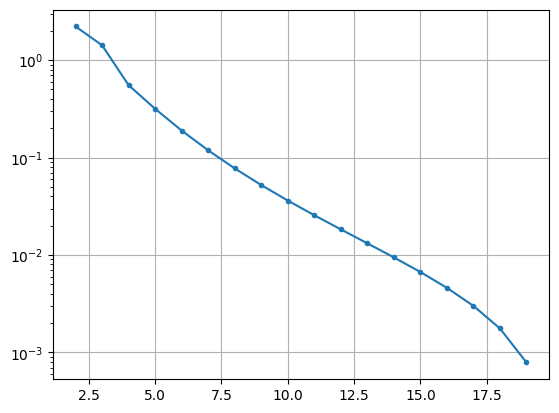

In [7]:
ns = range(2, N)
losses = []

for n1 in ns:
    ts = np.linspace(0, 1, n1+1)
    ps = fun(ts)
    c1s, c2s = compute_c1_c2(ps)
    loss = get_loss(ts, ps, c1s, c2s)
    losses.append(loss**0.5)

plt.figure()
plt.plot(ns, losses, '.-')
plt.yscale('log')
plt.grid()
plt.show()

Optimization

In [8]:
import torch
import scipy.optimize

In [9]:
# https://cs.nyu.edu/~sw4429//files/paper/sa23-bezier.pdf


def unwrap_cubic_spline_torch(cps, t0, t1):
    """Unwrap Bezier curve with control points c0,c1,c2,c3 between t0,t1 to
        polynomial spline with a0,a1,a2,a3 between 0,1"""
    coeffs = torch.tensor([
        [1, 0, 0, 0],
        [-3, 3, 0, 0],
        [3, -6, 3, 0],
        [-1, 3, -3, 1]
    ]).float() @ cps
    dt = t1-t0
    return torch.tensor([
        [1, t0, t0**2, t0**3],
        [0, dt, 2*t0*dt, 3*t0**2*dt],
        [0, 0, dt**2, 3*t0*dt**2],
        [0, 0, 0, dt**3]
    ]).float() @ coeffs


def get_loss_torch(ts, ps, c1s, c2s):
    assert ts[0].item() == 0.0
    assert ts[-1].item() == 1.0

    initial_t_torch = torch.tensor(initial_t).float()

    all_ss = []  # (s, is_initial, idx)
    for i, t in enumerate(initial_t):
        all_ss.append((t, True, i))
    for i, t in enumerate(ts):
        all_ss.append((t, False, i))
    all_ss.sort(key=lambda _: _[0])

    total_loss = 0.0
    sp0i, sp1i = 0, 0
    for (s0, g0, i0), (s1, g1, i1) in zip(all_ss[:-1], all_ss[1:]):
        if g0:
            sp0i = i0
        else:
            sp1i = i0
        if not s0 < s1:
            continue

        # first piece
        cps0 = torch.tensor([
            initial_p[sp0i], initial_c1[sp0i], initial_c2[sp0i],
            initial_p[sp0i+1]
        ]).float()
        t00, t01 = initial_t_torch[sp0i], initial_t_torch[sp0i+1]
        ts0 = ((s0-t00)/(t01-t00), (s1-t00)/(t01-t00))
        coeffs0 = unwrap_cubic_spline_torch(cps0, *ts0)

        # second piece
        cps1 = torch.concatenate([
            ps[sp1i], c1s[sp1i], c2s[sp1i], ps[sp1i+1]
        ]).reshape((4, 2))
        t10, t11 = ts[sp1i], ts[sp1i+1]
        ts1 = ((s0-t10)/(t11-t10), (s1-t10)/(t11-t10))
        coeffs1 = unwrap_cubic_spline_torch(cps1, *ts1)

        # integral
        dc = coeffs1 - coeffs0
        dc_pows = torch.einsum('ai,bi->ab', dc, dc) / torch.tensor(
            [[1, 2, 3, 4],
             [2, 3, 4, 5],
             [3, 4, 5, 6],
             [4, 5, 6, 7]]).float()
        loss = torch.sum(dc_pows)

        # add loss
        dx0 = (ts0[1]-ts0[0])/N
        dx1 = (ts1[1]-ts1[0])/(len(ts)-1)
        weight = dx0/(t01-t00) + dx1/(t11-t10)
        weight = dx0
        total_loss += weight * loss
    
    return total_loss

/tmp/ipykernel_391810/649938102.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  cps0 = torch.tensor([
/home/harry7557558/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


23 0.0018765562716975964


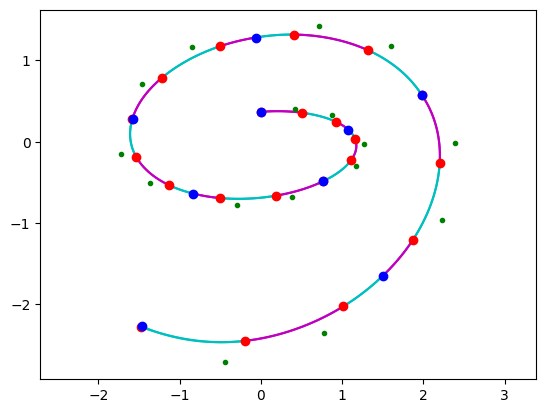

In [10]:

def optimize_coeffs_torch(ts, ps, c1s, c2s):
    assert ts[0] == 0.0
    assert ts[-1] == 1.0

    ts = torch.nn.Parameter(torch.tensor(ts).contiguous().float())
    ps = torch.nn.Parameter(torch.tensor(ps).contiguous().float())
    c1s = torch.nn.Parameter(torch.tensor(c1s).contiguous().float())
    c2s = torch.nn.Parameter(torch.tensor(c2s).contiguous().float())

    optimizer = torch.optim.LBFGS([ps, c1s, c2s], max_iter=50)

    loss = 0.0
    nfev = 0
    def closure():
        nonlocal nfev, loss
        optimizer.zero_grad()
        loss = get_loss_torch(ts, ps, c1s, c2s)
        loss.backward()
        ts.grad[0] = 0.0
        ts.grad[-1] = 0.0
        # print(loss.item()**0.5)
        nfev += 1
        return loss

    for epoch in range(1):
        optimizer.step(closure)

    return (nfev, loss.item()), (
        ts.detach().numpy(),
        ps.detach().numpy(),
        c1s.detach().numpy(),
        c2s.detach().numpy()
    )


n1 = 8
ts = np.linspace(0, 1, n1+1)
ps = fun(ts)
c1s, c2s = compute_c1_c2(ps)

(nfev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_torch(ts, ps, c1s, c2s)
print(nfev, loss**0.5)

plt.figure()
get_loss(ts, ps, c1s, c2s, True)
plt.plot(initial_p[:,0], initial_p[:,1], 'ro')
plt.plot(ps[:,0], ps[:,1], 'bo')
plt.plot(c1s[:,0], c1s[:,1], 'g.')
plt.plot(c2s[:,0], c2s[:,1], 'g.')
plt.axis("equal")
plt.show()

20 4.892248675345799 0.03377021104097366
24 2.0103596856129435 0.0029454983305186033
29 0.3050829507523748 0.00017416317132301629
30 0.09992946957800329 3.558345269993879e-05
27 0.03577337008850026 1.0468944310559891e-05
24 0.01407146430931215 5.639099072141107e-06
23 0.005990206348613176 3.521463440847583e-06
24 0.00272991470312294 1.9906076431652764e-06
25 0.001311431573893977 1.091345779968833e-06
20 0.0006553055397003147 5.194261802898836e-07
19 0.00033572840068749326 2.588985807960853e-07
19 0.00017377342410854112 1.2867889154222212e-07
16 8.939529682510575e-05 6.639078264925047e-08
13 4.478355174060997e-05 3.262656278479881e-08
13 2.120839366154152e-05 1.171910479769167e-08
11 9.036564577738484e-06 5.335001329598299e-09
7 3.1072344725699276e-06 5.193288465932255e-09
6 6.235777385867056e-07 4.526173214003393e-09


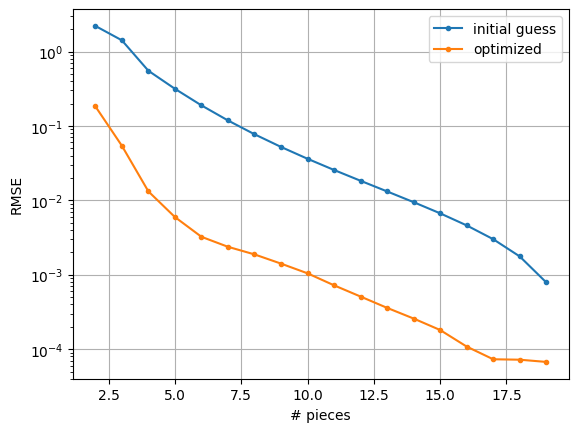

In [11]:
ns = range(2, N)
losses_0 = []
losses = []

for n1 in ns:
    ts = np.linspace(0, 1, n1+1)
    ps = fun(ts)
    c1s, c2s = compute_c1_c2(ps)
    loss0 = get_loss(ts, ps, c1s, c2s)
    (nfev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_torch(ts, ps, c1s, c2s)
    print(nfev, loss0, loss)
    losses_0.append(loss0**0.5)
    losses.append(loss**0.5)

plt.figure()
plt.plot(ns, losses_0, '.-', label="initial guess")
plt.plot(ns, losses, '.-', label="optimized")
plt.yscale('log')
plt.grid()
plt.xlabel("# pieces")
plt.ylabel("RMSE")
plt.legend()
plt.show()

40 0.001993430956785407
[0.00000000e+00 1.19253993e-04 9.54568386e-05 1.08003616e-04
 1.17719173e-04 1.17361546e-04 7.68899918e-05 1.20401382e-05
 0.00000000e+00]


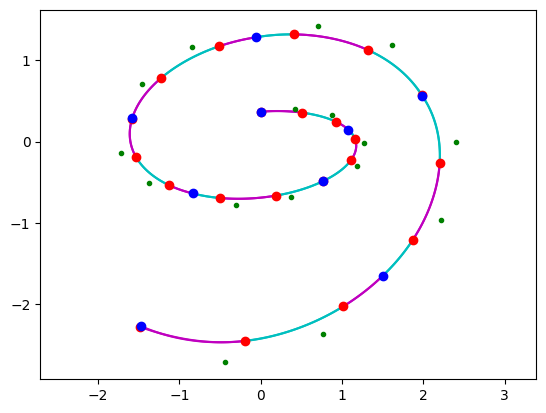

In [12]:
def optimize_coeffs_torch_with_ts(ts, ps, c1s, c2s):
    assert ts[0] == 0.0
    assert ts[-1] == 1.0

    softplus = torch.nn.Softplus()
    def map_ts(ts):
        ts = torch.exp(ts)
        # ts = softplus(ts)
        # ts = ts - torch.amin(ts) + 1.0
        ts = torch.cumsum(ts, 0)
        ts = torch.concatenate([torch.tensor([0.0]).float(), ts])
        return ts / ts[-1]
    
    def invmap_ts(ts):
        ts = torch.tensor(ts).float().contiguous()
        ts = ts[1:] - ts[:-1]
        return torch.log(ts)
        # return torch.log(torch.exp(ts)-1)
        # return ts

    ts_raw = torch.nn.Parameter(invmap_ts(ts))
    ps = torch.nn.Parameter(torch.tensor(ps).contiguous().float())
    c1s = torch.nn.Parameter(torch.tensor(c1s).contiguous().float())
    c2s = torch.nn.Parameter(torch.tensor(c2s).contiguous().float())

    optimizer = torch.optim.LBFGS(
        [ts_raw, ps, c1s, c2s],
        max_iter=50, line_search_fn="strong_wolfe")

    loss = 0.0
    nfev = 0
    def closure():
        nonlocal ts
        nonlocal nfev, loss
        optimizer.zero_grad()
        ts = map_ts(ts_raw)
        loss = get_loss_torch(ts, ps, c1s, c2s)
        loss.backward()
        # print(loss.item()**0.5)
        nfev += 1
        return loss

    for epoch in range(1):
        optimizer.step(closure)

    ts = map_ts(ts_raw)
    return (nfev, loss.item()), (
        ts.detach().numpy(),
        ps.detach().numpy(),
        c1s.detach().numpy(),
        c2s.detach().numpy()
    )


n1 = 8
ts = np.linspace(0, 1, n1+1)
ps = fun(ts)
c1s, c2s = compute_c1_c2(ps)
ts0 = np.array(ts)
ps0 = np.array(ps)

(nfev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_torch_with_ts(ts, ps, c1s, c2s)
print(nfev, loss**0.5)

print(ts-ts0)

plt.figure()
get_loss(ts, ps, c1s, c2s, True)
plt.plot(initial_p[:,0], initial_p[:,1], 'ro')
plt.plot(ps[:,0], ps[:,1], 'bo')
plt.plot(ps0[:,0], ps0[:,1], 'b.')
plt.plot(c1s[:,0], c1s[:,1], 'g.')
plt.plot(c2s[:,0], c2s[:,1], 'g.')
plt.axis("equal")
plt.show()

36 0.4109141230583191 0.022951554339274868
29 0.1541137993335724 0.059058082930692896
15 0.2069903165102005 0.022448942659055744
61 0.05754486098885536 0.00727586880431993
24 0.00019672281632665545 0.001402354881523838
38 5.508507456397638e-06 0.007886108338258275
40 3.973766979470383e-06 8.736060386233708e-05
27 2.0605755253200186e-06 0.0005787476983921139
30 2.1788023332192097e-06 0.0014556536805793174
22 4.984349288861267e-07 0.0003501295425433897
21 2.552106082021055e-07 9.29570998208819e-05
21 1.2795416637345625e-07 4.0269032239628925e-05
15 6.839590582785604e-08 1.762611111403418e-05
16 3.0937552963905546e-08 6.0608771654159405e-06
15 1.1530653765134957e-08 6.813753821245529e-07
13 5.041466355493185e-09 3.533432787908958e-07
8 5.432675642680351e-09 4.4997980014787657e-07
7 4.368419848077565e-09 1.3638127137959335e-07


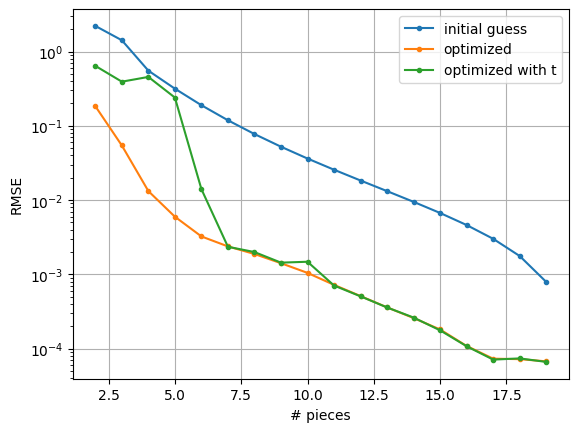

In [13]:
losses_t = []

for n1 in ns:
    ts = np.linspace(0, 1, n1+1)
    ps = fun(ts)
    c1s, c2s = compute_c1_c2(ps)
    ts0 = np.array(ts)
    (nfev, loss), (ts, ps, c1s, c2s) = optimize_coeffs_torch_with_ts(ts, ps, c1s, c2s)
    print(nfev, loss, (np.mean((ts-ts0)**2)**0.5))
    losses_t.append(loss**0.5)

plt.figure()
plt.plot(ns, losses_0, '.-', label="initial guess")
plt.plot(ns, losses, '.-', label="optimized")
plt.plot(ns, losses_t, '.-', label="optimized with t")
plt.yscale('log')
plt.grid()
plt.xlabel("# pieces")
plt.ylabel("RMSE")
plt.legend()
plt.show()